# Customer Churn Prediction

___

# Introduction

**About the problems**

Customer churn is the loss of clients or
customers. In order to avoid losing customers, a
company needs to examine why its customers have left
in the past and which features are more important to
determine who will churn in the future. Our task is
therefore to predict whether customers are about to
churn and which are the most important features to
get that prediction right. As in most prediction
problems, we will use machine learning.

**About the data**
*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents

# Data Importing and First Lookup

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
sns.set(style='ticks', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 5]})

In [2]:
os.chdir("../data")
data = pd.read_csv('telco.csv', sep=';')
data.head()

,customerid,region,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,2424-WVHPL,France,Male,1,No,No,1,Yes,No,Fiber optic,...,No,No,Yes,No,No,No,Electronic check,12.00,12,No
1,3679-XASPY,France,Female,0,Yes,Yes,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,Electronic check,13.00,13,No
2,2967-MXRAV,Germany,Male,0,Yes,Yes,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,Mailed check,18.80,18.8,No
3,8992-CEUEN,Germany,Female,0,No,No,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,Electronic check,18.85,18.85,No
4,9318-NKNFC,Germany,Male,0,No,No,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,Mailed check,18.85,18.85,Yes


In [ ]:
data.shape

(7043, 21)

Our data contains 7043 observations and 21 variable: <br>
*   20 independent variables
*   1 dependent variable with 2 classes



Lets look at the data type and missing values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   region            7043 non-null   object 
 2   gender            7043 non-null   object 
 3   seniorcitizen     7043 non-null   int64  
 4   partner           7043 non-null   object 
 5   dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   phoneservice      7043 non-null   object 
 8   multiplelines     7043 non-null   object 
 9   internetservice   7043 non-null   object 
 10  onlinesecurity    7043 non-null   object 
 11  onlinebackup      7043 non-null   object 
 12  deviceprotection  7043 non-null   object 
 13  techsupport       7043 non-null   object 
 14  streamingtv       7043 non-null   object 
 15  streamingmovies   7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


It have 18 object type (categorical variables), 2 int type (discrete variables), and 1 float type (continuous variable).<br>
And it looks like we don't have missing values.

There are 2 variables with incorrect type:
1.   seniorcitizen : must be object type because it is categorical variable.
2.   totalcharges : must be numerical type

We have to change the 1 and 0 values in seniorcitizen to 'Yes' and 'No' accordingly (because the other categorical variables has this value) to have better interpretation when we make visualization.

Next, we want to examine totalcharges why it has an object type.

In [ ]:
# Change seniorcitizen column values to Yes and No
map_yesno = {1:'Yes', 0:'No'}
data['seniorcitizen'] = data['seniorcitizen'].map(map_yesno)

In [ ]:
# Check whether columns value contains  other than numeric and alphabet
for col in data.columns:
  print(col, data.loc[~data[col].astype(str).str.contains(pat='[0-9a-zA-Z]'), col].tolist())

customerid []
region []
gender []
seniorcitizen []
partner []
dependents []
tenure []
phoneservice []
multiplelines []
internetservice []
onlinesecurity []
onlinebackup []
deviceprotection []
techsupport []
streamingtv []
streamingmovies []
paperlessbilling []
paymentmethod []
monthlycharges []
totalcharges [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
churn []


It turns out that the totalcharges column has a value containing ' '(space). This is why the data type is object. <br>
It is necessary to change the value containing ' '(space) and change the data type to numeric.

In [ ]:
# Change data type to numeric
# Nonconvertible value will automatically inputed with NaN
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce')

After we change the data type, there must be some missing values appear.

In [ ]:
data.isna().sum()

customerid           0
region               0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

Missing values imputation will be done after train test split to avoid information leakage in the test set.

# Exploratory Data Analysis

### Preparation

Make some function to plot custom visualization.

In [ ]:
def countplot_annot(nrow, ncol, columns, data, 
                    rotate=None, rcol=None,
                    t_height=25):
  '''
  Function untuk ploting sns.counplot dengan penambahan presentase
  di atas bar. (Versi tanpa hue)
  '''
  for index, col in enumerate(columns):
    plt.subplot(nrow, ncol, index + 1)

    order = sorted(data[col].unique())
    ax = sns.countplot(data=data, x=col, order=order)
    ax.set_ylabel('')

    if rotate != None:
      if col in rcol:
        plt.xticks(rotation=rotate)

    total = len(data)
    for p in ax.patches:
      ax.text(p.get_x() + p.get_width()/2., p.get_height() + t_height, 
              '{:.1f}%'.format(100*p.get_height()/total), ha="center")

def countplot_annot_hue(nrow, ncol, columns, hue, data,
                        rotate=None, rcol=None,
                        t_height=30):
  '''
  Function untuk ploting sns.counplot dengan penambahan presentase
  di atas bar. (Versi dengan hue)
  '''
  for index, col in enumerate(columns):
    plt.subplot(nrow, ncol, index + 1)

    order = sorted(data[col].unique())
    ax = sns.countplot(data=data, x=col, hue=hue, order=order)
    ax.set_ylabel('')
    
    if rotate != None:
      if col in rcol:
        plt.xticks(rotation=rotate)

    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + t_height, 
                '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + t_height, 
                '{0:.0%}'.format(height_r/total), ha="center")


Divide columns to their category to make easier visualization.

In [ ]:
for col in data.columns:
  print(col, data[col].unique())

customerid ['2424-WVHPL' '3679-XASPY' '2967-MXRAV' ... '2775-SEFEE' '4075-WKNIU'
 '5709-LVOEQ']
region ['France' 'Germany' 'England']
gender ['Male' 'Female']
seniorcitizen ['Yes' 'No']
partner ['No' 'Yes']
dependents ['No' 'Yes']
tenure [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  19  17
  18  20  21  25  22  23  24  26  27  28  29  30  33  32  31  35  36  34
  37  38  40  39  42  41  43  44  46  48  45  47  49  52  50  51  53  55
  54  58  56  59  57  60  62  61  63  68  67  64  65  66  69  71  70  72
 120  96]
phoneservice ['Yes' 'No']
multiplelines ['No' 'No phone service' 'Yes']
internetservice ['Fiber optic' 'No' 'DSL']
onlinesecurity ['No' 'No internet service' 'Yes']
onlinebackup ['No' 'No internet service' 'Yes']
deviceprotection ['No' 'No internet service' 'Yes']
techsupport ['Yes' 'No internet service' 'No']
streamingtv ['No' 'No internet service' 'Yes']
streamingmovies ['No' 'No internet service' 'Yes']
paperlessbilling ['No' 'Yes']
paymentmethod ['Elec

In [ ]:
num_cols = ['tenure', 'monthlycharges', 'totalcharges']
cat_cols = [col for col in data.columns if col not in num_cols + ['customerid', 'churn']]
target_col = 'churn'

In [ ]:
data.shape

(7043, 21)

In [ ]:
len(num_cols + cat_cols + [target_col])

20

### Univariate Analysis

#### Target Class

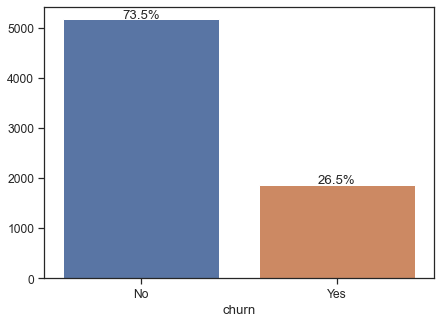

In [ ]:
countplot_annot(1, 1, columns=[target_col], data=data)

Our data have slightly imbalance class distribution. It will cause a model hard to identify the minority class.

*   No (Non Churn) : 73.5%
*   Yes (Churn) : 26.5%

**Consideration :** <br>
Required to tune the model or do resampling to meet our objective (detect the minority class).

#### Numerical Features

In [ ]:
data[num_cols].describe()

,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7032.000000
mean,32.401107,64.751874,2294.275919
std,24.606849,30.097858,2316.761157
min,1.000000,12.000000,12.000000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3801.400000
max,120.000000,118.750000,22345.600000


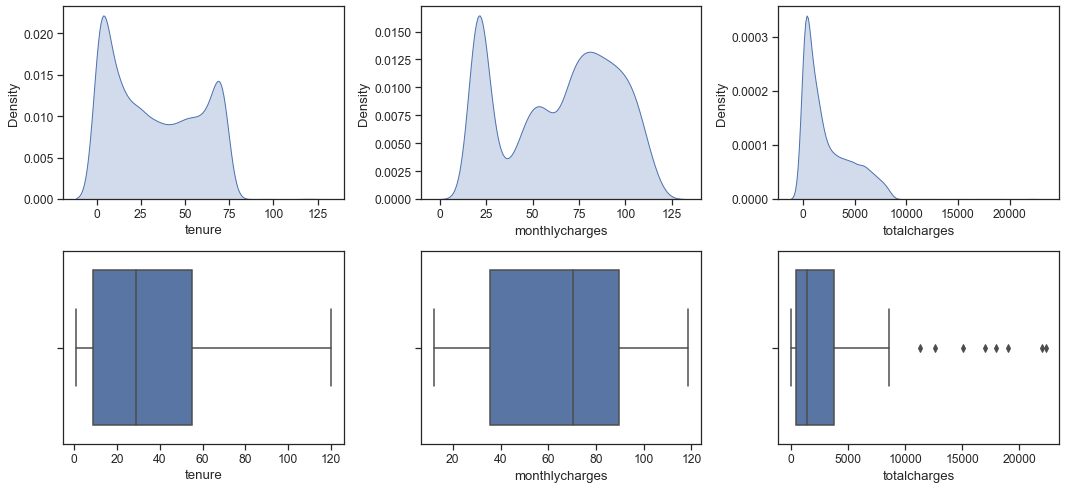

In [ ]:
plt.figure(figsize=(15,7))
for i, col in enumerate(num_cols):
  plt.subplot(2,3,i+1)
  sns.kdeplot(data=data, x=col, fill=True)
for i, col in enumerate(num_cols):
  plt.subplot(2,3,i+4)
  sns.boxplot(data=data, x=col)
plt.tight_layout()

* Tenure and monthly charges have a bimodal distribution. Meanwhile, total charges feature  has highly right skewed distribution.
* There are many outliers on total charges feature.

#### Categorical Features

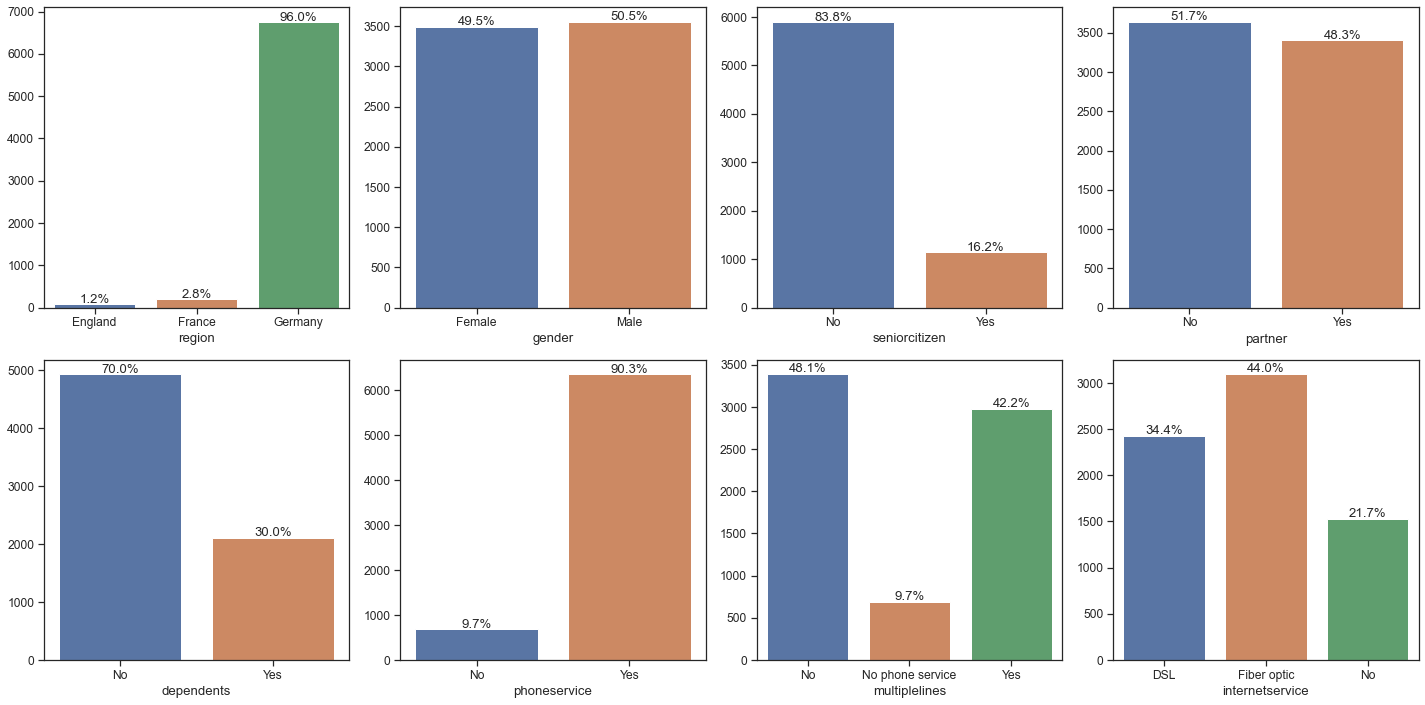

In [ ]:
plt.figure(figsize=(20,10))
countplot_annot(2, 4, cat_cols[:8], data)
plt.tight_layout()

From this visualization we got much information about our data.
*   Most of customer are from Germany (96%).
*   Proportion of Male and Female customer is about the same.
*   Senior citizen is minority here (just 16.2%).
*   Customer who do not have partner slighly have more proportion.
*   Most of customer do not have dependents (70%).
*   Most of customer has a phone service (90.3%).
*   Customer who has multiple lines are slighly lower tha who don't.
*   44% of customers registered to Fiber Optic, 34.4% to DSL, and 21.7% who do not register to internet service. 

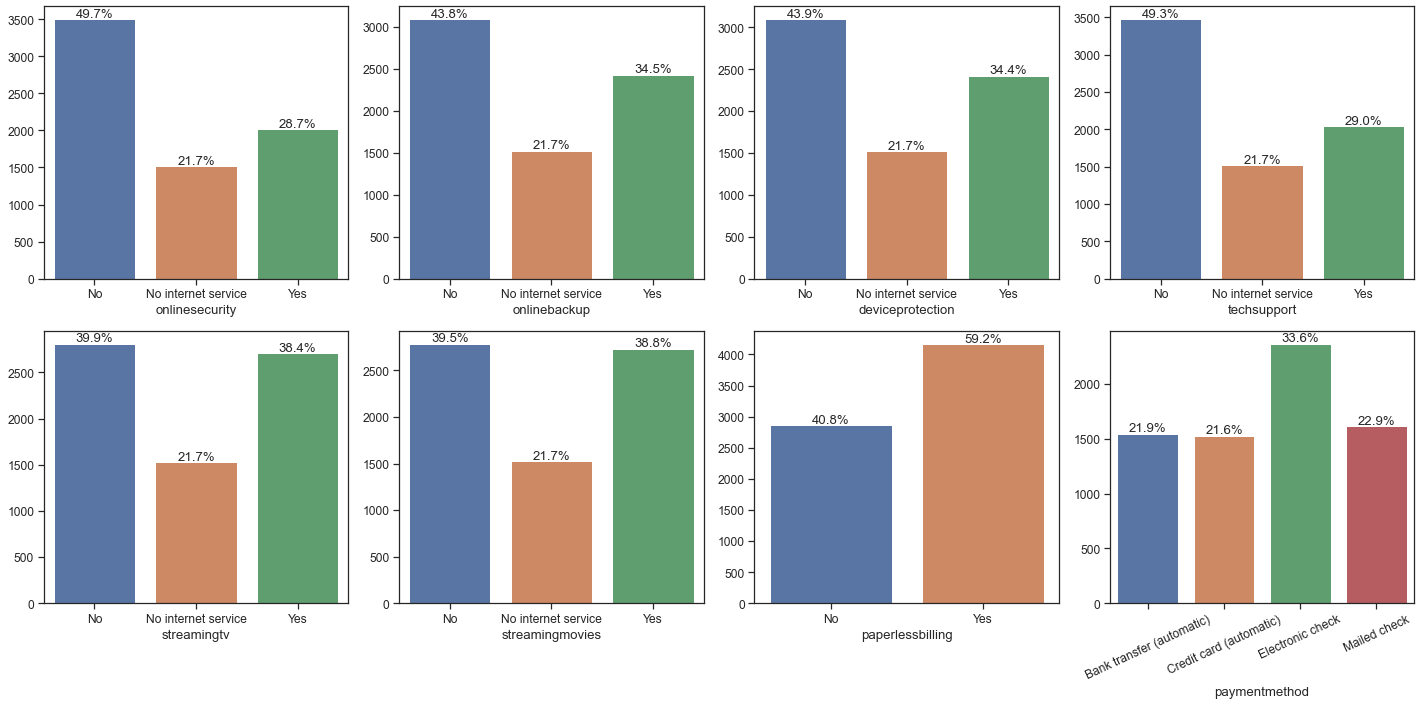

In [ ]:
plt.figure(figsize=(20,10))
countplot_annot(2, 4, cat_cols[8:], data,
                rotate=25, rcol=['paymentmethod'])
plt.tight_layout()

Lets do for the rest
* Many customers don't have online security, online backup, device protection and tech support compared to those who do.
* Most of the customers use paper less billing and pay by electronic check.



### Multivariate Analysis

#### Numerical Features

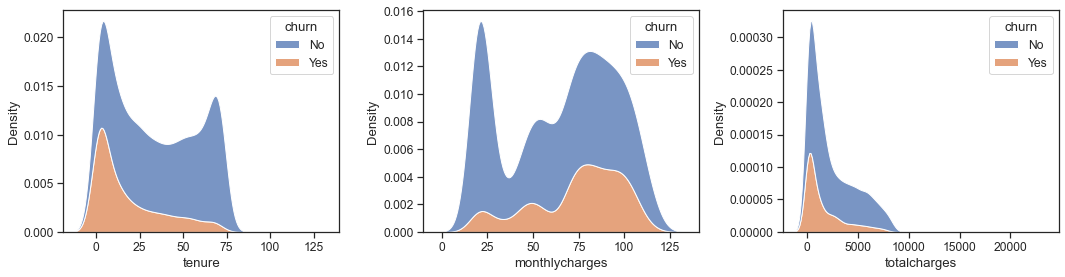

In [ ]:
plt.figure(figsize=(15,4))
for i, col in enumerate(num_cols):
  plt.subplot(1,3,i+1)
  sns.kdeplot(data=data, x=col, hue=target_col,
              multiple='stack')
plt.tight_layout()

* In feature tenure and monthly charges, negative (non churn) class has a bimodal distribution, while positive class does not.
* As for total charges, the distribution between the two classes is similar.

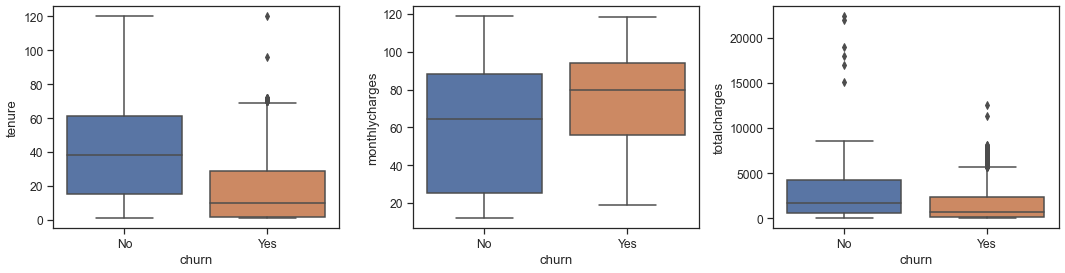

In [ ]:
plt.figure(figsize=(15,4))
for i, col in enumerate(num_cols):
  plt.subplot(1,3,i+1)
  sns.boxplot(data=data, x=target_col, y=col)
plt.tight_layout()

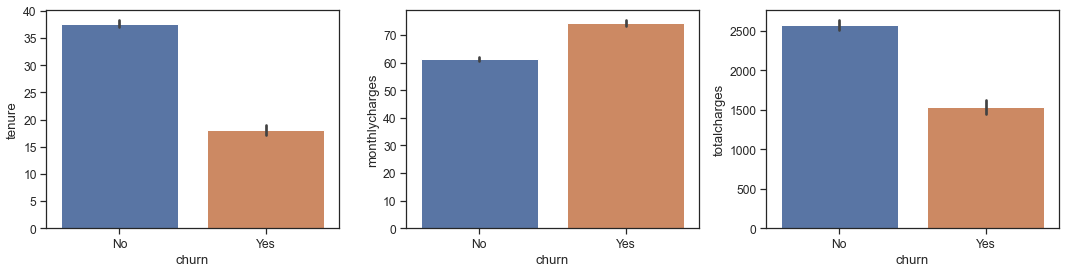

In [ ]:
plt.figure(figsize=(15,4))
for i, col in enumerate(num_cols):
  plt.subplot(1,3,i+1)
  sns.barplot(data=data.dropna(), x=target_col, y=col)
plt.tight_layout()

From the comparison of the independent and dependent numerical variables above on average it can be concluded:
* Customers with low tenure tend to have higher churn
* Customers with high monthly charges tend to have higher churn
* Customers with lower total charges tend to have higher churn

#### Categorical Features

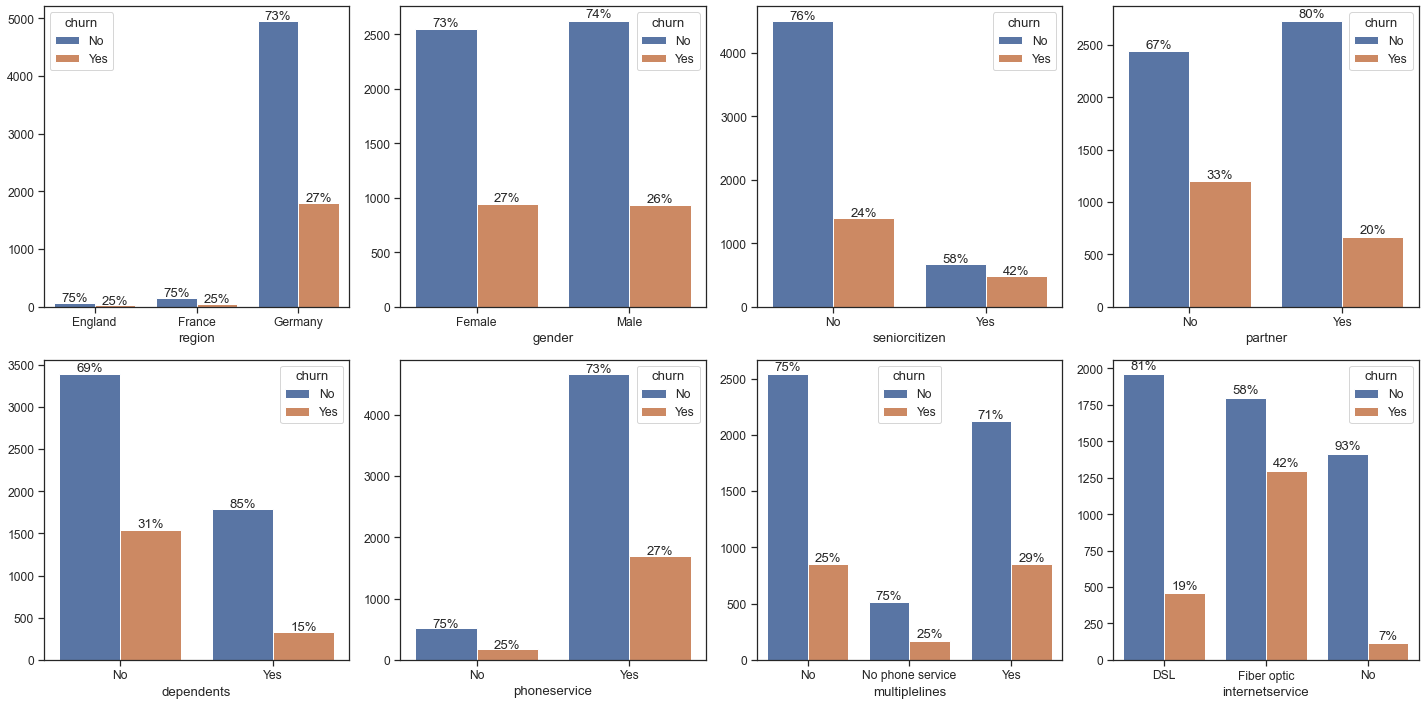

In [ ]:
plt.figure(figsize=(20,10))
countplot_annot_hue(2, 4, columns=cat_cols[:8], hue=target_col, data=data)
plt.tight_layout()

*   From this comparation, the tendency for churn are more occurs on customers from the senior citizens, who do not have a partner, and who do not have dependents.
*   In addition, customers who subscribe to fiber optic have a higher churn rate when compared to other services.

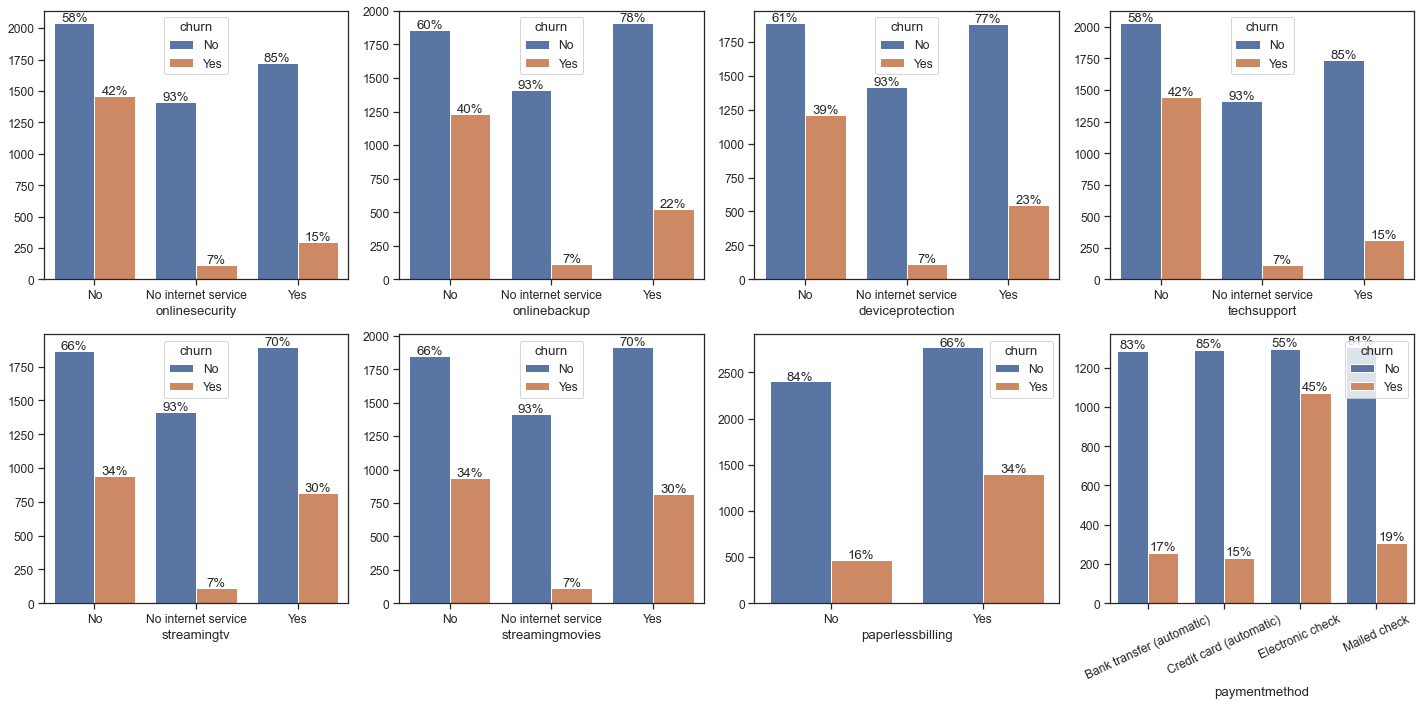

In [ ]:
plt.figure(figsize=(20,10))
countplot_annot_hue(2, 4, columns=cat_cols[8:], hue=target_col, data=data,
                rotate=25, rcol=['paymentmethod'], t_height=15)
plt.tight_layout()

* Customers who do not subscribe to online security, online backup, device protection, and tech support have a higher churn rate when compared to customers who subscribe to this service.

* In streaming tv and streaming movies services, there is no significant difference between customers who churn and those who don't. (4% different)

* In terms of payment, it appears that customers who using paper less billing and electronic check payment methods have higher churn.

#### Features Corelation

In [ ]:
mapping = {'Yes' : 1, 'No' : 0}
data[target_col] = data[target_col].map(mapping)

In [ ]:
data[num_cols + [target_col]].corr()

,tenure,monthlycharges,totalcharges,churn
tenure,1.000000,0.248350,0.816151,-0.350766
monthlycharges,0.248350,1.000000,0.644675,0.193502
totalcharges,0.816151,0.644675,1.000000,-0.196341
churn,-0.350766,0.193502,-0.196341,1.000000


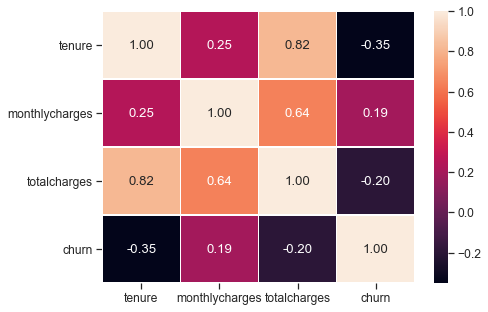

In [ ]:
sns.heatmap(data[num_cols + [target_col]].corr(), annot=True, linewidths=.5, fmt= '.2f')

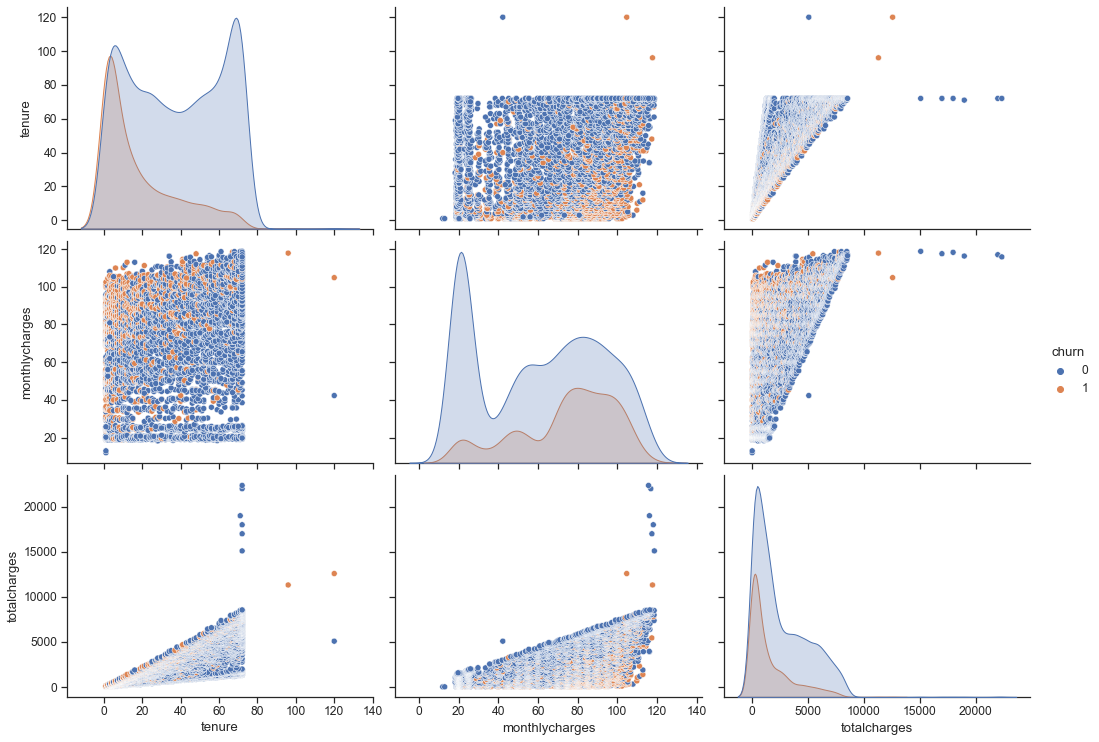

In [ ]:
sns.pairplot(data[num_cols + [target_col]], hue=target_col, height=3.5, aspect=1.4)

* Tenure and total charges have a strong positive correlation.
* The monthly charges and total charges features have a positive correlation.
* Meanwhile, tenure and monthly charges have a weak positive correlation.

We can see some outliers that are very far away from the data set. <br>
Judging from the data distribution, it is possible that these outliers were caused by input errors.

Outlier handling will be carried out at the data processing step after this.

# Data Processing

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(data[num_cols + cat_cols + [target_col]],
                               test_size=0.2, random_state=14)

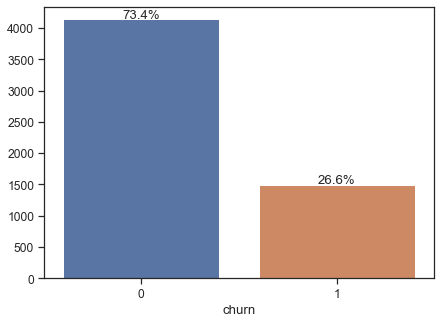

In [ ]:
countplot_annot(1, 1, columns=[target_col], data=train)

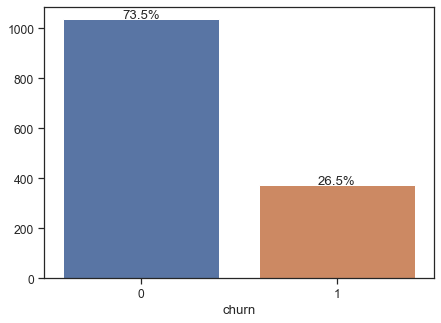

In [ ]:
countplot_annot(1, 1, columns=[target_col], data=test, t_height=5)

### Outlier Handling

We will remove this outlier with a threshold of 10000 for total charges and 80 for tenure. <br>
Outliers above those values will be discarded from the data set.

##### Before remove outlier

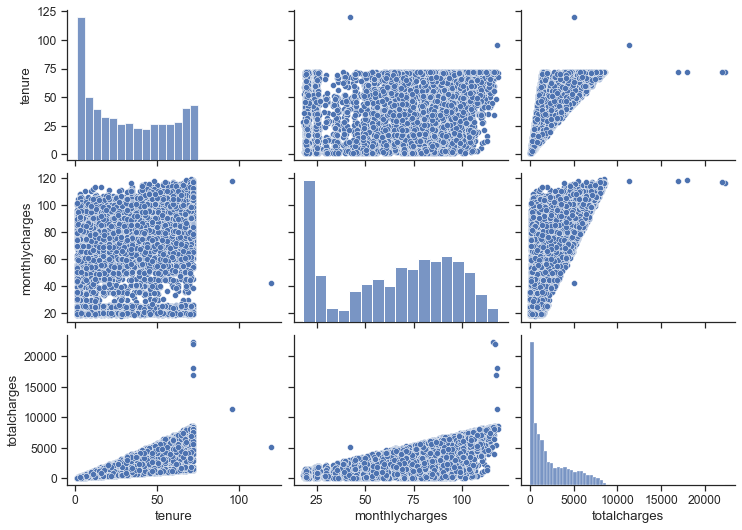

In [ ]:
sns.pairplot(train[num_cols], height=2.5, aspect=1.4)

In [ ]:
train = train.drop(index=train[train['tenure']>80].index)
train = train.drop(index=train[train['totalcharges']>10000].index)

test = test.drop(index=test[test['tenure']>80].index)
test = test.drop(index=test[test['totalcharges']>10000].index)

##### After remove outlier

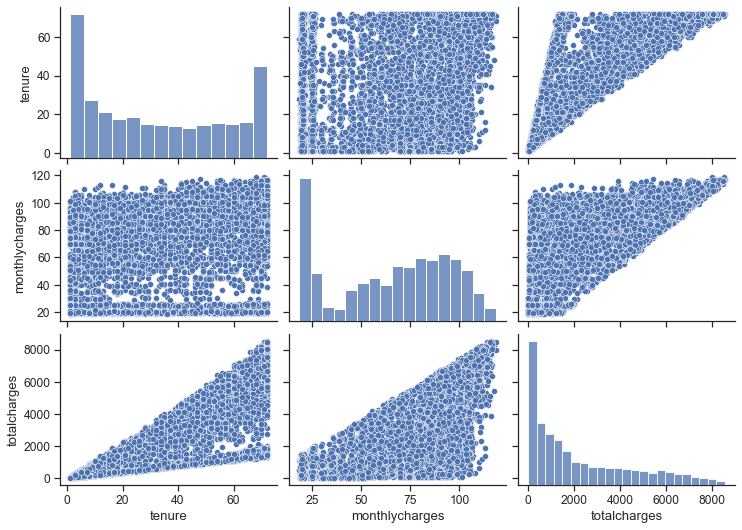

In [ ]:
sns.pairplot(train[num_cols], height=2.5, aspect=1.4)

### Missing Value Handling

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
na_col = pd.DataFrame(train.isna().sum()) / train.shape[0]*100
na_col.columns = ['NA Train']
na_col['NA Test'] = test.isna().sum().values / test.shape[0]*100
round(na_col.sort_values(by='NA Train', ascending=False).T, 2)

,totalcharges,tenure,onlinesecurity,paymentmethod,paperlessbilling,streamingmovies,streamingtv,techsupport,deviceprotection,onlinebackup,internetservice,monthlycharges,multiplelines,phoneservice,dependents,partner,seniorcitizen,gender,region,churn
NA Train,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA Test,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


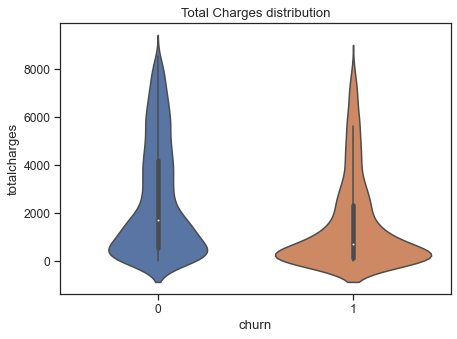

In [ ]:
sns.violinplot(data=train, y='totalcharges', x=target_col)
plt.title('Total Charges distribution')
plt.show()

Because total charges feature have highly right skewed distribution, missing value imputation will be done with median value.

In [ ]:
imputer = SimpleImputer(strategy='median')
train['totalcharges'] = imputer.fit_transform(train['totalcharges'].values.reshape(-1, 1))
test['totalcharges'] = imputer.transform(test['totalcharges'].values.reshape(-1, 1))

In [ ]:
na_col = pd.DataFrame(train.isna().sum()) / train.shape[0]*100
na_col.columns = ['NA Train']
na_col['NA Test'] = test.isna().sum().values / test.shape[0]*100
round(na_col.sort_values(by='NA Train', ascending=False).T, 2)

,tenure,monthlycharges,paymentmethod,paperlessbilling,streamingmovies,streamingtv,techsupport,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,dependents,partner,seniorcitizen,gender,region,totalcharges,churn
NA Train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA Test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Enginering

Make categorize (binning) for tenure feature.

In [ ]:
def tenure_bin(df):
  if df['tenure'] <= 12:
    return '0-1 year'
  elif df['tenure'] > 12 and df['tenure'] <= 24:
    return '1-2 year'
  elif df['tenure'] > 24 and df['tenure'] <= 36:
    return '2-3 year'
  elif df['tenure'] > 36 and df['tenure'] <= 48:
    return '3-4 year'
  elif df['tenure'] > 48 and df['tenure'] <= 60:
    return '4-5 year'
  elif df['tenure'] > 60:
    return '5-6 year'

In [ ]:
train['tenure_bin'] = train.apply(lambda x: tenure_bin(x), axis=1)
test['tenure_bin'] = test.apply(lambda x: tenure_bin(x), axis=1)

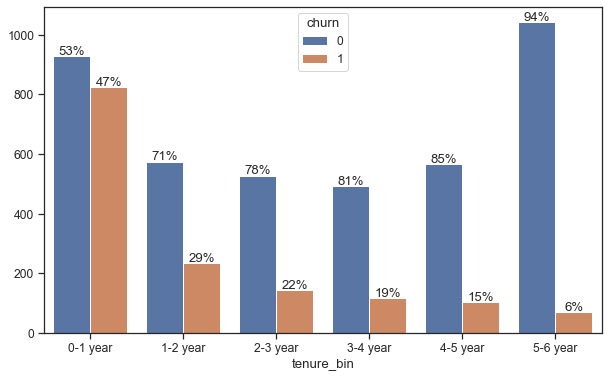

In [ ]:
plt.figure(figsize=(10,6))
countplot_annot_hue(1,1, columns=['tenure_bin'], hue=target_col, data=train,
                    t_height=5)

With binning, we can more clearly see the distribution comparison on tenure feature. <br>
Customers with tenure less than 1 year tend to have higher churn compare to the other.

### Categorical Encoding

In [ ]:
map_yn = {'Yes': 1, 'No': 0}
map_gender = {'Male': 1, 'Female': 0}
map_tenure = {'0-1 year': 1,
              '1-2 year': 2,
              '2-3 year': 3,
              '3-4 year': 4,
              '4-5 year': 5,
              '5-6 year': 6}

In [ ]:
for col in ['seniorcitizen', 'partner', 'dependents', 'phoneservice', 'paperlessbilling']:
  train[col] = train[col].map(map_yn)
  test[col] = test[col].map(map_yn)

train['gender'] = train['gender'].map(map_gender)
test['gender'] = test['gender'].map(map_gender)

train['tenure_bin'] = train['tenure_bin'].map(map_tenure)
test['tenure_bin'] = test['tenure_bin'].map(map_tenure)

In [ ]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [ ]:
train.head()

,tenure,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,phoneservice,paperlessbilling,churn,...,streamingtv_No,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No,streamingmovies_No internet service,streamingmovies_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
5712,72,65.65,4664.50,1,0,1,1,0,1,0,...,0,0,1,0,0,1,1,0,0,0
3369,71,19.70,1301.10,1,0,1,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3980,19,95.15,1789.25,0,0,0,0,1,1,1,...,1,0,0,0,0,1,0,0,1,0
6278,67,86.15,5883.85,0,0,1,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0
4013,71,24.50,1816.20,1,0,1,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0


### Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
features = [col for col in train.columns if col != 'churn']
X_train = train[features]
y_train = train['churn']

X_test = test[features]
y_test = test['churn']

In [ ]:
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Modeling

At this modeling step we will use 4 machine learning, namely:

1. Logistic Regression
2. Desicion Tree
3. K-Neirest Neighbors
4. XGBoost Classifier

We will compare the performance of several models.

Because we have imbalanced classes, we will focus on roc auc score with higher recall.

In situations where we want to detect instances of a minority class, we are usually concerned more so with recall than precision, as in the context of detection, it is usually more costly to miss a positive instance than to falsely label a negative instance.

### Preparation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nPrecision={:0.3f} | Recall={:0.3f}\nAccuracy={:0.3f} | F1 Score={:0.3f}".format(
                precision, recall, accuracy, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
def model_eval(model, X_train, y_train, 
               scoring_='roc_auc', cv_=5):
  
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_predprob = model.predict_proba(X_train)[:,1]
           
    cv_score = cross_val_score(model, X_train, y_train, cv=cv_, scoring=scoring_)
    print('Model Report on Train and CV Set:')
    print('--------')
    print('Train Accuracy: {:0.6f}'.format(metrics.accuracy_score(y_train, train_pred)))
    print('Train AUC Score: {:0.6f}'.format(metrics.roc_auc_score(y_train, train_predprob)))
    print('CV AUC Score: Mean - {:0.6f} | Std - {:0.6f} | Min - {:0.6f} | Max - {:0.6f} \n'.format(
        np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

In [ ]:
def test_eval(model, X_test, y_test):

    pred = model.predict(X_test)
    predprob = model.predict_proba(X_test)[:,1]
    
    print('Model Report on Test Set:')
    print('--------')
    print('Classification Report \n', metrics.classification_report(y_test, pred))

    conf = metrics.confusion_matrix(y_test, pred)
    group_names = ['True Negative', 'False Positive', 'False Negtive', 'True Positive']
    make_confusion_matrix(conf, percent=False, group_names=group_names,
                          figsize=(14,5), title='Confusion Matrix')

    plt.subplot(1,2,2)
    fpr, tpr, _ = metrics.roc_curve(y_test, predprob)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve\nAUC Score: {:0.3f}'.format(metrics.roc_auc_score(y_test, predprob)))
    plt.legend()

### Model Fitting and Evaluation

#### Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=9999)
model_eval(lr, X_train_sc, y_train)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.805615
Train AUC Score: 0.841049
CV AUC Score: Mean - 0.837321 | Std - 0.003221 | Min - 0.831449 | Max - 0.841139 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      1034
           1       0.68      0.52      0.59       372

    accuracy                           0.81      1406
   macro avg       0.76      0.72      0.73      1406
weighted avg       0.80      0.81      0.80      1406



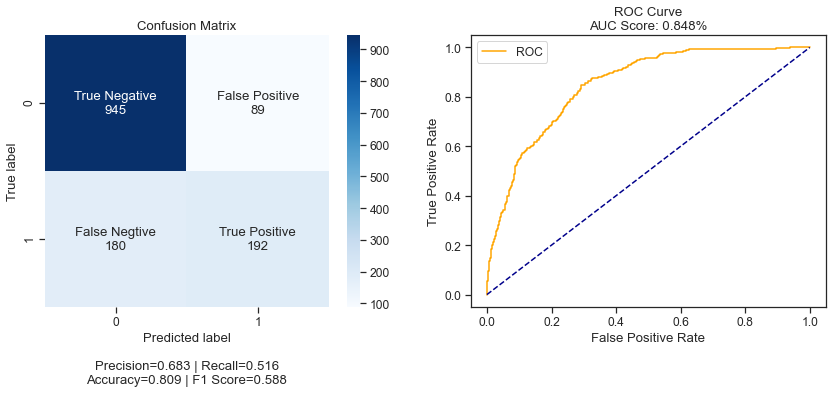

In [ ]:
test_eval(lr, X_test_sc, y_test)

#### Desicion Tree

In [ ]:
tree = DecisionTreeClassifier()
model_eval(tree, X_train, y_train)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.998223
Train AUC Score: 0.999991
CV AUC Score: Mean - 0.647861 | Std - 0.016105 | Min - 0.625327 | Max - 0.667479 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      1034
           1       0.49      0.51      0.50       372

    accuracy                           0.73      1406
   macro avg       0.66      0.66      0.66      1406
weighted avg       0.73      0.73      0.73      1406



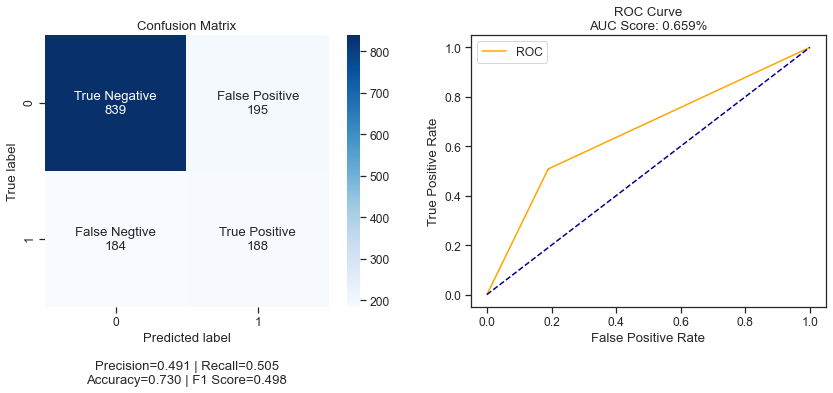

In [ ]:
test_eval(tree, X_test, y_test)

#### K-Neirest Neighbors

In [ ]:
knn = KNeighborsClassifier()
model_eval(knn, X_train_sc, y_train)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.832623
Train AUC Score: 0.890344
CV AUC Score: Mean - 0.751474 | Std - 0.004456 | Min - 0.744370 | Max - 0.757839 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1034
           1       0.55      0.48      0.51       372

    accuracy                           0.76      1406
   macro avg       0.68      0.67      0.67      1406
weighted avg       0.75      0.76      0.75      1406



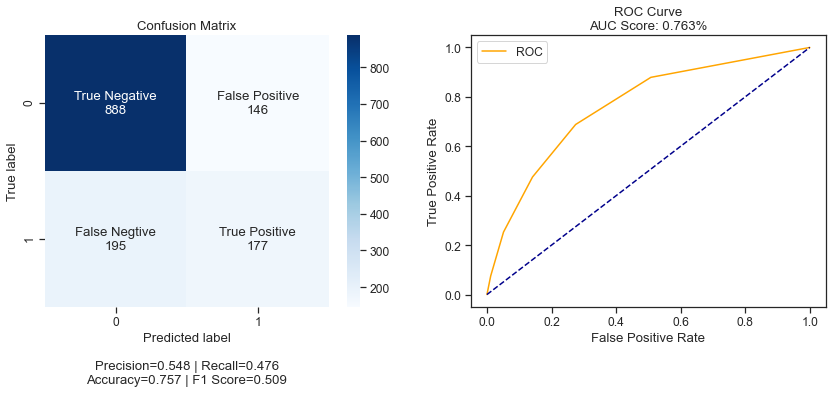

In [ ]:
test_eval(knn, X_test_sc, y_test)

#### XGBoost Classifier

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist',
                        seed=14)
model_eval(xgb_clf, X_train, y_train)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.936389
Train AUC Score: 0.983966
CV AUC Score: Mean - 0.808600 | Std - 0.009825 | Min - 0.794575 | Max - 0.820530 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1034
           1       0.65      0.55      0.59       372

    accuracy                           0.80      1406
   macro avg       0.75      0.72      0.73      1406
weighted avg       0.79      0.80      0.80      1406



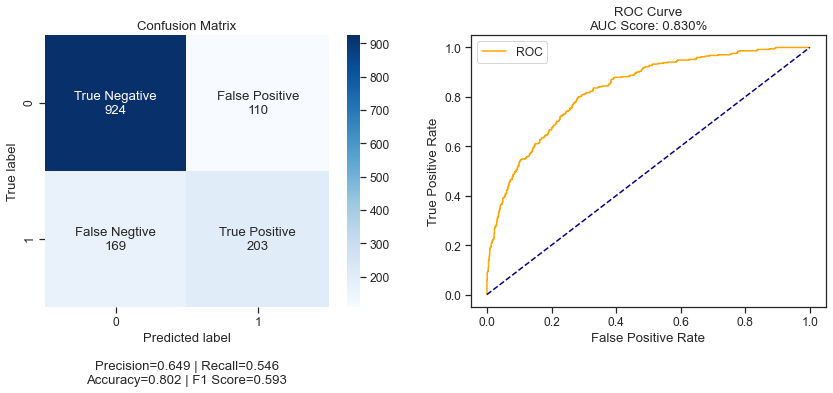

In [ ]:
test_eval(xgb_clf, X_test, y_test)

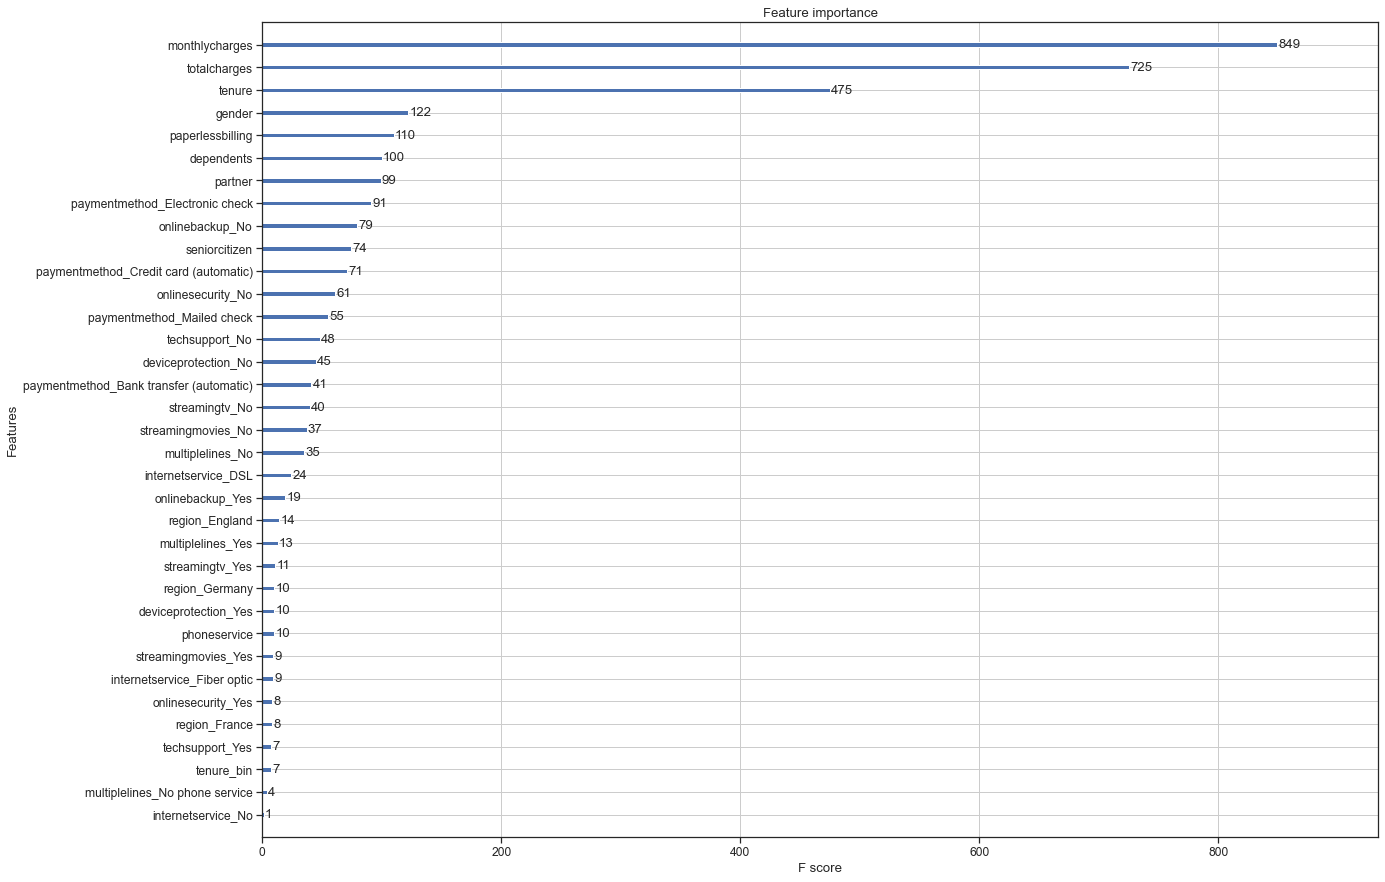

In [ ]:
plt.figure(figsize=(20,15))
xgb.plot_importance(xgb_clf, ax=plt.gca())

**Summary**:
* Logistic Regression has pretty good results, neither overfit nor underfit (CV AUC 0.837), but recall is only 0.52
* Desicion Tree is too overfit in the training set
* KNN results are quite good (slightly overfit on the traning set), but the AUC score is still far below the Logistic Regression
* XGBoost results are similar to Logistic Regression with slightly superior CV AUC score of 0.839



Without tuning, all models struggled to detect positive classes with an average recall around 0.5

##### Hyperparameter Tunning

In [ ]:
# Step 1: Get initial fix learning_rate and n_estimators
test1 = {'n_estimators':range(20,101,10)}
grid1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, 
                                               max_depth=5, 
                                               min_child_weight=1, 
                                               gamma=0, 
                                               subsample=0.8, 
                                               colsample_bytree=0.8,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=1, 
                                               seed=14,
                                               tree_method='gpu_hist'), 
                                               param_grid = test1, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid1.fit(X_train, y_train)
grid1.best_params_, grid1.best_score_

({'n_estimators': 70}, 0.8400041173701442)

In [ ]:
# Step 2: Tune max_depth and min_child_weight
test2 = {'max_depth': range(3,10,2),
         'min_child_weight': range(1,6,2)}
grid2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05,
                                               n_estimators=70,
                                               max_depth=5, 
                                               min_child_weight=1, 
                                               gamma=0, 
                                               subsample=0.8, 
                                               colsample_bytree=0.8,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=1, 
                                               seed=14, 
                                               tree_method='gpu_hist'), 
                                               param_grid = test2, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid2.fit(X_train, y_train)
grid2.best_params_, grid2.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.8415346069913143)

In [ ]:
# Step 2b: Tune max_depth and min_child_weight
test2 = {'max_depth': [4,5,6],
         'min_child_weight': [4,5,6]}
grid2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05,
                                               n_estimators=70,
                                               max_depth=5, 
                                               min_child_weight=5, 
                                               gamma=0, 
                                               subsample=0.8, 
                                               colsample_bytree=0.8,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=1, 
                                               seed=14, 
                                               tree_method='gpu_hist'),  
                                               param_grid = test2, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid2.fit(X_train, y_train)
grid2.best_params_, grid2.best_score_

({'max_depth': 4, 'min_child_weight': 6}, 0.8419653925037384)

In [ ]:
# Step 3: Tune gamma
test3 = {'gamma': [i/10.0 for i in range(0,5)]}
grid3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05,
                                               n_estimators=70,
                                               max_depth=4, 
                                               min_child_weight=6, 
                                               gamma=0, 
                                               subsample=0.8, 
                                               colsample_bytree=0.8,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=1, 
                                               seed=14, 
                                               tree_method='gpu_hist'),  
                                               param_grid = test3, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid3.fit(X_train, y_train)
grid3.best_params_, grid3.best_score_

({'gamma': 0.0}, 0.8419653925037384)

In [ ]:
# Step 4: Tune subsample and colsample_bytree
test4 = {'subsample':[i/10.0 for i in range(6,10)],
         'colsample_bytree':[i/10.0 for i in range(6,10)]}
grid4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05,
                                               n_estimators=70,
                                               max_depth=4, 
                                               min_child_weight=6, 
                                               gamma=0, 
                                               subsample=0.8, 
                                               colsample_bytree=0.8,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=1, 
                                               seed=14, 
                                               tree_method='gpu_hist'), 
                                               param_grid = test4, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid4.fit(X_train, y_train)
grid4.best_params_, grid4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.8421577307194499)

In [ ]:
# Step 5: Tuning scale_pos_weight
test5 = {'scale_pos_weight': [i/10 for i in range(1,11)]}
grid5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05,
                                               n_estimators=70,
                                               max_depth=4, 
                                               min_child_weight=6, 
                                               gamma=0, 
                                               subsample=0.7, 
                                               colsample_bytree=0.6,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=1, 
                                               seed=14, 
                                               tree_method='gpu_hist'), 
                                               param_grid = test5, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid5.fit(X_train, y_train)
grid5.best_params_, grid5.best_score_

({'scale_pos_weight': 0.9}, 0.8424394902469203)

In [ ]:
# Step 6: Tuning n_estimators and learning_rate
test6 = {'learning_rate': [0.005],
         'n_estimators': range(100,1001,200)}
grid6 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05,
                                               n_estimators=70,
                                               max_depth=4, 
                                               min_child_weight=6, 
                                               gamma=0, 
                                               subsample=0.7, 
                                               colsample_bytree=0.6,
                                               objective= 'binary:logistic', 
                                               scale_pos_weight=0.9, 
                                               seed=14, 
                                               tree_method='gpu_hist'), 
                                               param_grid = test6, 
                                               scoring='roc_auc',
                                               n_jobs=-1, cv=5)
grid6.fit(X_train, y_train)
grid6.best_params_, grid6.best_score_

({'learning_rate': 0.005, 'n_estimators': 900}, 0.8428265039499567)

In [ ]:
params = {'max_depth': range(3,10,2),
         'min_child_weight': range(1,6,2),
         'gamma': [i/10.0 for i in range(0,5)],
         'subsample':[i/10.0 for i in range(6,10)],
         'colsample_bytree':[i/10.0 for i in range(6,10)],
         'scale_pos_weight': range(1,11)}
random = RandomizedSearchCV(estimator = XGBClassifier(learning_rate=0.01, 
                                                      n_estimators=1000,
                                                      objective='binary:logistic', 
                                                      seed=14, 
                                                      tree_method='gpu_hist'), 
                           param_distributions = params,
                           n_iter=100,
                           scoring='roc_auc',
                           n_jobs=-1, cv=5)
random.fit(X_train, y_train)
random.best_params_, random.best_score_

({'colsample_bytree': 0.8,
  'gamma': 0.4,
  'max_depth': 3,
  'min_child_weight': 5,
  'scale_pos_weight': 2,
  'subsample': 0.7},
 0.8413534251344889)

In [ ]:
params = {'max_depth': range(3,10,2),
         'min_child_weight': range(1,6,2),
         'gamma': [i/10.0 for i in range(0,5)],
         'subsample':[i/10.0 for i in range(6,10)],
         'colsample_bytree':[i/10.0 for i in range(6,10)],
         'scale_pos_weight': [i/10 for i in range(1,11)],
         'learning_rate': [0.005, 0.01],
         'n_estimators': range(100,2001,200)}
random = RandomizedSearchCV(estimator = XGBClassifier(objective= 'binary:logistic', 
                                                     seed=14, tree_method='gpu_hist'), 
                           param_distributions = params,
                           n_iter=100,
                           scoring='roc_auc',
                           n_jobs=-1, cv=5)
random.fit(X_train, y_train)
random.best_params_, random.best_score_

({'colsample_bytree': 0.9,
  'gamma': 0.3,
  'learning_rate': 0.01,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 900,
  'scale_pos_weight': 0.1,
  'subsample': 0.8},
 0.8431523887565154)

CV AUC Score : Mean - 0.841 | Std - 0.021 | Min - 0.805 | Max - 0.870 

--------
XGBoost Classifier Model Report on Test set

Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1034
           1       0.59      0.69      0.63       373

    accuracy                           0.79      1407
   macro avg       0.73      0.76      0.74      1407
weighted avg       0.80      0.79      0.79      1407



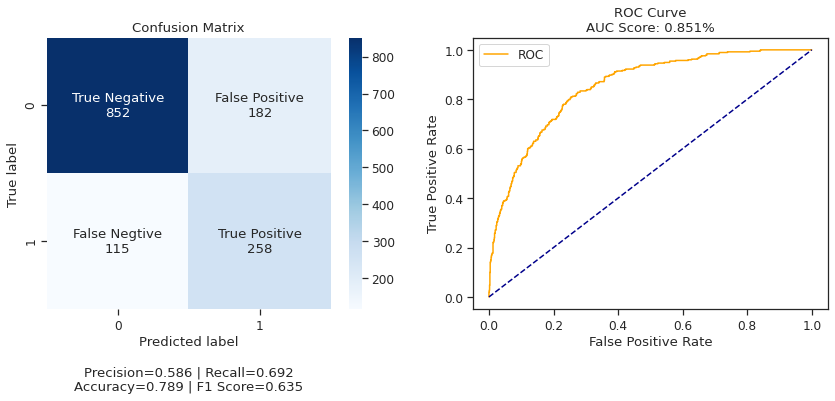

In [ ]:
model_eval(random.best_estimator_, X_train, y_train, X_test, y_test,
           model_name='XGBoost Classifier')

CV AUC Score : Mean - 0.843 | Std - 0.023 | Min - 0.804 | Max - 0.875 

--------
XGBoost Classifier Model Report on Test set

Classification Report 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1034
           1       0.83      0.03      0.05       373

    accuracy                           0.74      1407
   macro avg       0.79      0.51      0.45      1407
weighted avg       0.76      0.74      0.64      1407



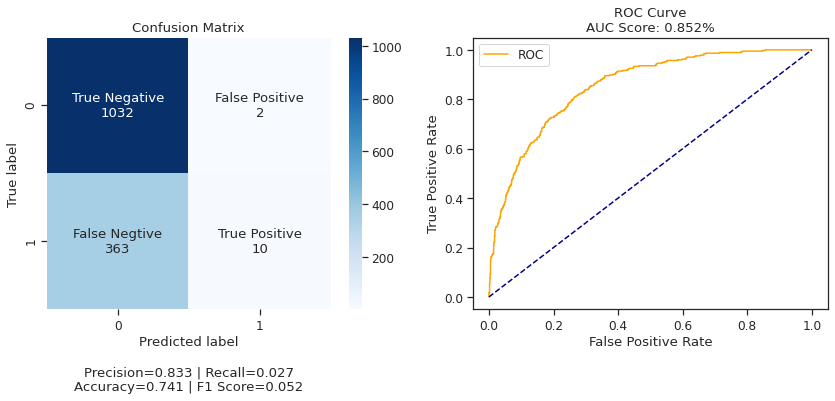

In [ ]:
model_eval(random.best_estimator_, X_train, y_train, X_test, y_test,
           model_name='XGBoost Classifier')

CV AUC Score : Mean - 0.842 | Std - 0.021 | Min - 0.805 | Max - 0.870 

--------
XGBoost Classifier Model Report on Test set

Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.77      0.83      1034
           1       0.55      0.78      0.64       373

    accuracy                           0.77      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.77      0.78      1407



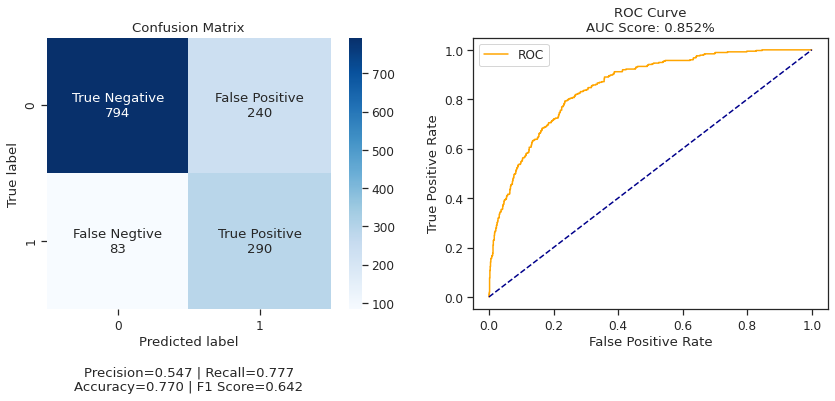

In [ ]:
xgb_gpu = XGBClassifier(learning_rate=0.005,
                    n_estimators=1700,
                    max_depth=3,
                    min_child_weight=5,
                    gamma=0.1, 
                    subsample=0.6, 
                    colsample_bytree=0.7,
                    objective= 'binary:logistic',
                    scale_pos_weight=2.7663989290495317, 
                    seed=14, 
                    tree_method='gpu_hist')
model_eval(xgb_gpu, X_train, y_train, X_test, y_test,
           model_name='XGBoost Classifier')

### Model with Weighted Parameter

#### Logistic Regression

In [ ]:
lr_cw = LogisticRegression(max_iter=9999,
                           class_weight='balanced',
                           C=11.288378916846883,
                           penalty='l2')
model_eval(lr_cw, X_train_sc, y_train)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.756397
Train AUC Score: 0.842698
CV AUC Score: Mean - 0.839119 | Std - 0.003256 | Min - 0.833625 | Max - 0.843816 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      1034
           1       0.53      0.76      0.62       372

    accuracy                           0.76      1406
   macro avg       0.71      0.76      0.72      1406
weighted avg       0.80      0.76      0.77      1406



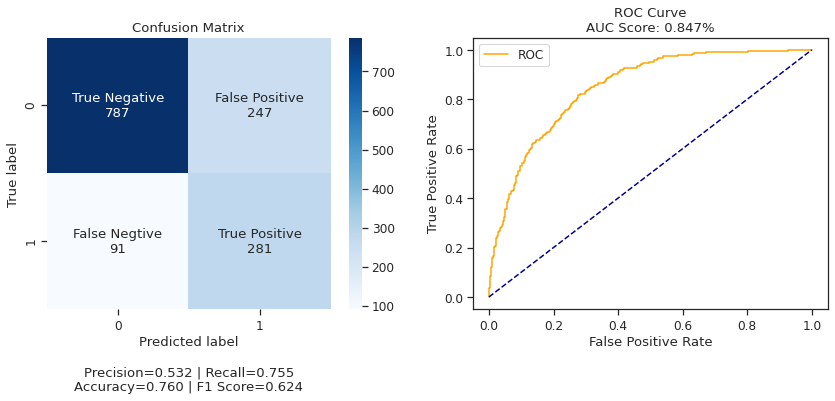

In [ ]:
test_eval(lr_cw, X_test_sc, y_test)

##### Hyperparameter Tunning

In [ ]:
params = {'penalty': ['l1', 'l2'],
          'C': np.logspace(-4,4,20)}

grid = GridSearchCV(estimator=LogisticRegression(max_iter=9999,
                                                 class_weight='balanced'), 
                     param_grid=params, 
                     scoring='roc_auc',
                     n_jobs=-1, cv=5)

grid.fit(X_train_sc, y_train)
grid.best_params_, grid.best_score_

({'C': 11.288378916846883, 'penalty': 'l2'}, 0.8384089057679759)

#### XGBoost Classifier

In [ ]:
ratio = float(np.sum(train['churn'] == 0)) / np.sum(train['churn'] == 1)

xgb_cw = XGBClassifier(learning_rate=0.005,
                       n_estimators=1700,
                       max_depth=3,
                       min_child_weight=5,
                       gamma=0.1, 
                       subsample=0.8, 
                       colsample_bytree=0.6,
                       objective='binary:logistic',
                       scale_pos_weight=ratio,
                       tree_method='gpu_hist',
                       seed=14)

model_eval(xgb_cw, X_train, y_train)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.767413
Train AUC Score: 0.864499
CV AUC Score: Mean - 0.840313 | Std - 0.005340 | Min - 0.830511 | Max - 0.846386 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.77      0.83      1034
           1       0.55      0.78      0.64       372

    accuracy                           0.77      1406
   macro avg       0.73      0.77      0.74      1406
weighted avg       0.81      0.77      0.78      1406



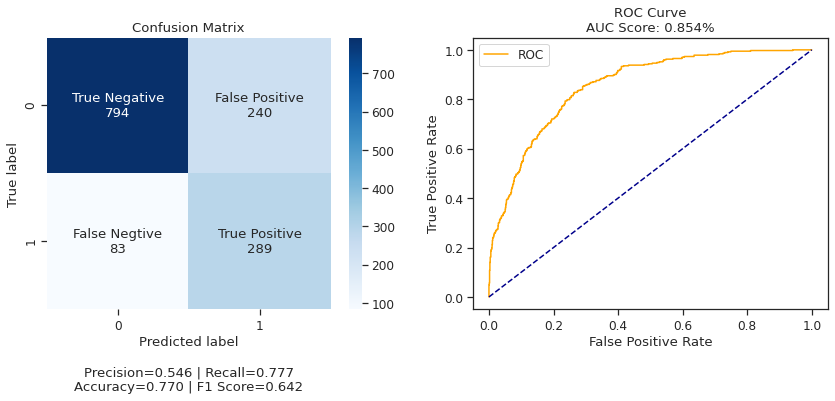

In [ ]:
test_eval(xgb_cw, X_test, y_test)

##### Hyperparameter Tunning

In [ ]:
estimator1 = XGBClassifier(learning_rate=0.1,
                           objective='binary:logistic',
                           scale_pos_weight=ratio,
                           tree_method='gpu_hist',
                           seed=14)

params1 = {'n_estimators': stats.randint(150, 1000)}

grid1 = GridSearchCV(estimator=estimator1, 
                     param_grid=params1, 
                     scoring='roc_auc',
                     n_jobs=-1, cv=5)

grid1.fit(X_train, y_train)
grid1.best_params_, grid1.best_score_)

In [ ]:
estimator2 = XGBClassifier(learning_rate=0.1,
                           n_estimators=1000,
                           objective='binary:logistic',
                           scale_pos_weight=ratio,
                           tree_method='gpu_hist',
                           seed=14)

params2 = {'max_depth': stats.randint(3,10),
           'min_child_weight': stats.randint(1,6),
           'gamma': [i/10.0 for i in range(0,5)],
           'subsample':[i/10.0 for i in range(6,10)],
           'colsample_bytree':[i/10.0 for i in range(6,10)]}


{'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }
randomcv = RandomizedSearchCV(estimator=estimator2,
                              param_distributions=params2,
                              n_iter=50,
                              scoring='roc_auc',
                              n_jobs=-1, cv=5)

randomcv.fit(X_train, y_train)
randomcv.best_params_, randomcv.best_score_

{'n_estimators': 500, 'learning_rate': 0.01} 0.8418746113534166
CV AUC Score : Mean - 0.841875 | Std - 0.021205 | Min - 0.805480 | Max - 0.870482 

--------
XGBoost Classifier (Weighted) Model Report on Test set

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      1034
           1       0.53      0.77      0.63       373

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



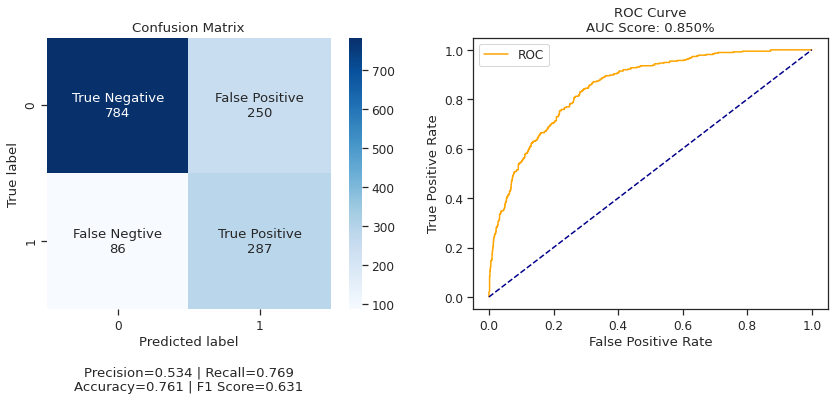

In [ ]:
estimator1 = XGBClassifier(learning_rate=0.01,
                       n_estimators=1000,
                       max_depth=3,
                       min_child_weight=5,
                       gamma=0.1, 
                       subsample=0.8, 
                       colsample_bytree=0.6,
                       objective='binary:logistic',
                       scale_pos_weight=ratio,
                       tree_method='gpu_hist',
                       seed=14)




model_eval(rs_cv.best_estimator_, X_train, y_train, X_test, y_test,
           model_name='XGBoost Classifier (Weighted)')

In [ ]:
ratio = float(np.sum(train['churn'] == 0)) / np.sum(train['churn'] == 1)

estimator = XGBClassifier(max_depth=3,
                       min_child_weight=5,
                       gamma=0.1, 
                       subsample=0.8, 
                       colsample_bytree=0.6,
                       objective='binary:logistic',
                       scale_pos_weight=ratio,
                       tree_method='gpu_hist',
                       seed=14)

params = {'learning_rate': [0.005, 0.01, 0.05],
          'n_estimators': range(100,2001,200)}

grid = GridSearchCV(estimator=estimator, 
                     param_grid=params, 
                     scoring='roc_auc',
                     n_jobs=-1, cv=5)

grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

model_eval(grid.best_estimator_, X_train, y_train, X_test, y_test,
           model_name='XGBoost Classifier (Weighted)')

{'learning_rate': 0.005, 'n_estimators': 1300} 0.842162504944346
CV AUC Score : Mean - 0.842163 | Std - 0.021074 | Min - 0.805929 | Max - 0.870685 

--------
XGBoost Classifier (Weighted) Model Report on Test set

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.76      0.83      1034
           1       0.54      0.77      0.64       373

    accuracy                           0.77      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.77      0.78      1407



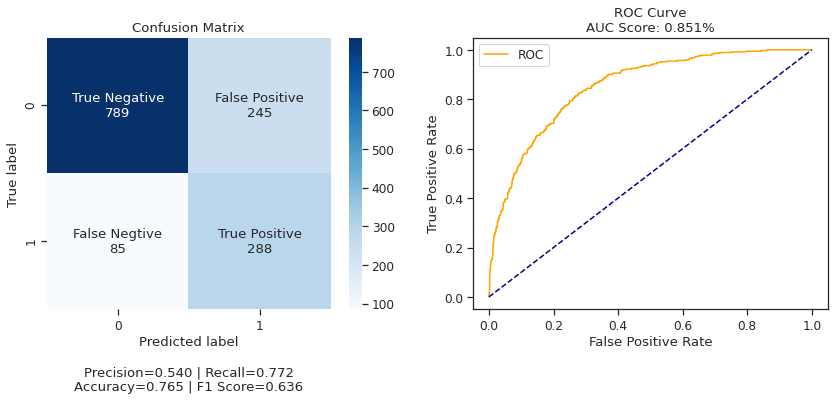

In [ ]:
print(grid.best_params_, grid.best_score_)

model_eval(grid.best_estimator_, X_train, y_train, X_test, y_test,
           model_name='XGBoost Classifier (Weighted)')

**Summary:**

By tuning the class weight parameter, we get a model that can give a higher recall but with a decrease in Accuracy.
* The results of Logistic Regression evaluation on the test set obtained Recall 0.755 and AUC Score 0.847.
* XGBoost was slightly higher with Recall 0.777 and AUC Score 0.854 on the test set.

### Model with Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X_train.values, y_train.values)

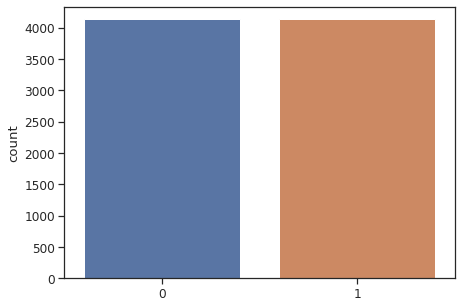

In [ ]:
sns.countplot(x=y_over)

#### Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=9999,
                        C=1.623776739188721,
                        penalty='l2')
model_eval(lr, X_over, y_over)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.764457
Train AUC Score: 0.846790
CV AUC Score: Mean - 0.844929 | Std - 0.011031 | Min - 0.832237 | Max - 0.859103 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.77      0.83      1034
           1       0.54      0.75      0.62       372

    accuracy                           0.76      1406
   macro avg       0.71      0.76      0.72      1406
weighted avg       0.80      0.76      0.77      1406



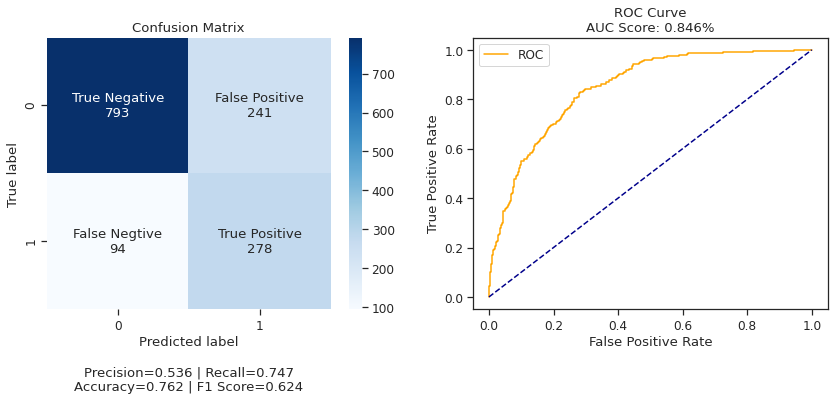

In [ ]:
test_eval(lr, X_test, y_test)

##### Hyperparameter Tunning

In [ ]:
params = {'penalty': ['l1', 'l2'],
          'C': np.logspace(-4,4,20)}

grid = GridSearchCV(estimator=LogisticRegression(max_iter=9999), 
                     param_grid=params, 
                     scoring='roc_auc',
                     n_jobs=-1, cv=5)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

{'C': 1.623776739188721, 'penalty': 'l2'} 0.8380584767917995


#### XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
xgb_os = XGBClassifier(learning_rate=0.005,
                       n_estimators=1700,
                       max_depth=3,
                       min_child_weight=4,
                       gamma=0.1, 
                       subsample=0.6, 
                       colsample_bytree=0.7,
                       objective= 'binary:logistic',
                       scale_pos_weight=1,
                       tree_method='gpu_hist', 
                       seed=14)
model_eval(xgb_os, X_over, y_over)

Model Report on Train and CV Set:
--------
Train Accuracy: 0.866804
Train AUC Score: 0.945238
CV AUC Score: Mean - 0.936870 | Std - 0.069216 | Min - 0.831444 | Max - 0.993631 



Model Report on Test Set:
--------
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1034
           1       0.64      0.59      0.61       372

    accuracy                           0.80      1406
   macro avg       0.75      0.73      0.74      1406
weighted avg       0.80      0.80      0.80      1406



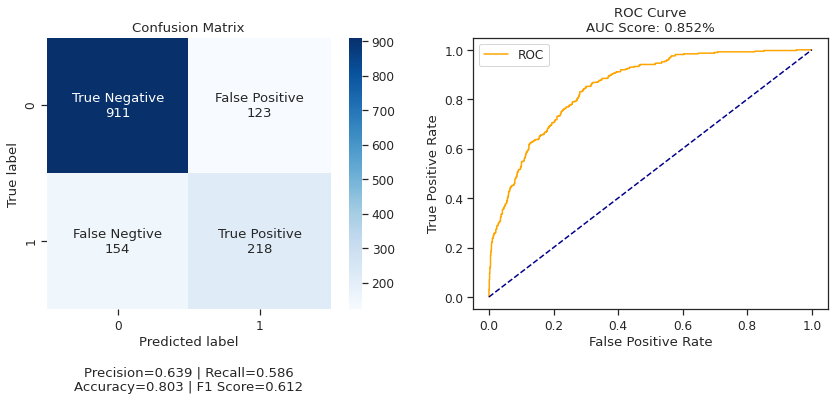

In [ ]:
test_eval(xgb_os, X_test.values, y_test.values)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

estimator = XGBClassifier(learning_rate=0.01,
                          n_estimators=700,
                          objective= 'binary:logistic',
                          scale_pos_weight=1,
                          tree_method='gpu_hist', 
                          seed=14)

params = {'max_depth': range(3,10,1),
          'min_child_weight': range(1,6,1),
          'gamma': [i/10.0 for i in range(0,5)],
          'subsample':[i/10.0 for i in range(6,10)],
          'colsample_bytree':[i/10.0 for i in range(6,10)]}

rs_cv = RandomizedSearchCV(estimator=estimator, 
                           param_distributions=params,
                           n_iter=100,
                           scoring='roc_auc',
                           n_jobs=-1, cv=5)

rs_cv.fit(X_over, y_over)
rs_cv.best_params_, rs_cv.best_score_

({'colsample_bytree': 0.8,
  'gamma': 0.4,
  'max_depth': 6,
  'min_child_weight': 2,
  'subsample': 0.8},
 0.9377001872003076)

**Summary:**
* With the oversampling method, similar results are obtained for Logistic Regression compared to previous class weighted model.
* However, the XGBoost results were too overfit for the training and cross validation sets. The metrics result is less than what we expected because Recall is only 0.59